# AdventureWorks Försäljningsanalys
I denna analys undersöker jag AdventureWorks-databasen för att besvara affärsfrågor som exempelvis:
- Produktkategorier och deras försäljning
- Försäljningstrender över tid
- Regional försäljning

Jag använder SQL för att hämta data och Python för visualisering och analys.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus


server = 'NADINE'
database = 'AdventureWorks2025'
driver = quote_plus("ODBC Driver 18 for SQL server")


connection_string = (
    f"mssql+pyodbc://@{server}/{database}"
    f"?driver={driver}&trusted_connection=yes&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)


try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta", e)

Anslutning till SQL Server lyckades


C:\Users\nadin\AppData\Local\Temp\ipykernel_31060\2159151561.py:21: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


In [48]:
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)

## Visualisering 1: Antal produkter per kategori
Hur många produkter finns i varje kategori?

Tabeller som används:
- Production.ProductCategory
- Production.ProductSubcategory
- Production.Product

Plan:
- JOINA tabellerna
- Räkna DISTINCT produkter per kategori
- Skapa vertikalt stapeldiagram
- Analysera resultatet: Förklara vilken kategori som har flest/minst produkter.

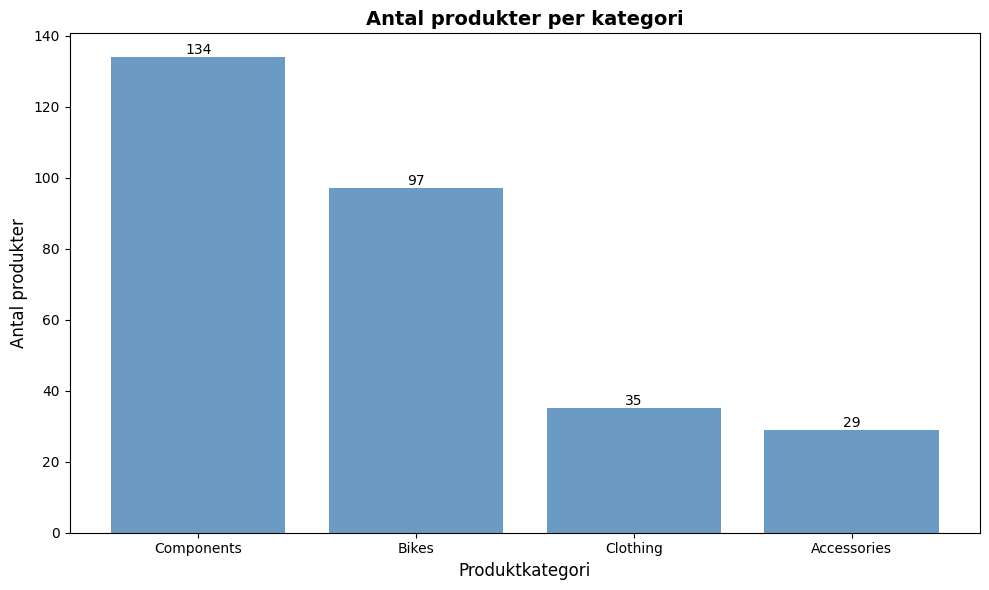

In [49]:
query_vis1 = """
SELECT
	pc.Name AS CategoryName,
	COUNT(DISTINCT p.ProductID) AS ProductCount
FROM Production.ProductCategory pc
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY ProductCount DESC
"""

df_vis1 = query_df(query_vis1)

fig, ax = plt.subplots(figsize=(10,6))

bars = ax.bar(df_vis1['CategoryName'], df_vis1['ProductCount'], color='steelblue', alpha=0.8)

for bar in bars:
    height = bar.get_height()
    ax.text(
    bar.get_x() + bar.get_width()/2,
    height,
    f'{int(height)}',
    ha='center',
    va='bottom'
    )

ax.set_xlabel('Produktkategori', fontsize=12)
ax.set_ylabel('Antal produkter', fontsize=12)
ax.set_title('Antal produkter per kategori', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### Insikter - Antal produkter per kategori
Components är största kategorin med 134 produkter. Accessories är minst med 29 produkter.
Detta indikerar på att företaget är starkt fokuserat på komponenter och reservdelar. Och att accessories kan vara ett utvecklingsområde.

## Visualisering 2: Försäljning per produktkategori
Vilka produktkategorier generar mest intäkter?

Tabeller som används:
- Production.ProductCategory
- Production.ProductSubcategory
- Production.Product
- Sales.SalesOrderDetail

Plan:
- JOINA tabellerna
- Beräkna försäljning från högst till lägst
- Skapa horisontellt stapeldiagram
- Analysera resultatet: Förklara vilken kategori som är störst och minst, med exakta siffror.

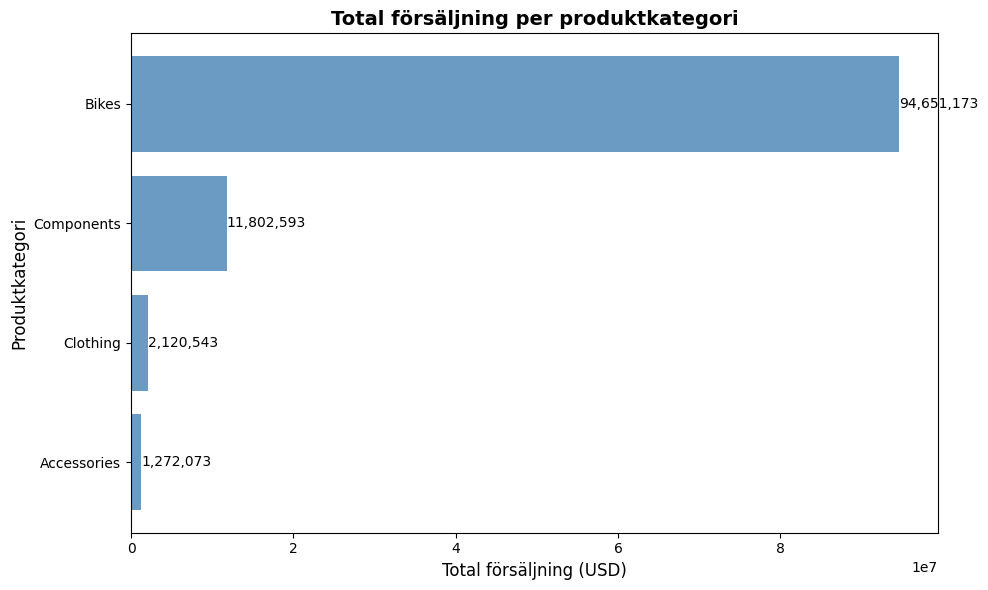

In [73]:
query_vis2 = """
SELECT
	pc.Name AS CategoryName,
	SUM(sod.LineTotal) AS TotalSales
FROM Production.ProductCategory pc
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
INNER JOIN Sales.SalesOrderDetail sod ON p.ProductID = sod.ProductID
GROUP BY pc.Name
ORDER BY TotalSales DESC
"""

df_vis2 = query_df(query_vis2)

fig, ax = plt.subplots(figsize=(10,6))

bars = ax.barh(df_vis2['CategoryName'], df_vis2['TotalSales'], color='steelblue', alpha=0.8)

for bar in bars:
    width = bar.get_width()
    ax.text(
    width,
    bar.get_y() + bar.get_height()/2,
    f'{width:,.0f}',
    va='center',
    ha='left'
    )

ax.set_xlabel('Total försäljning (USD)', fontsize=12)
ax.set_ylabel('Produktkategori', fontsize=12)
ax.set_title('Total försäljning per produktkategori', fontsize=14, fontweight='bold')
ax.invert_yaxis()

plt.tight_layout()
plt.show()

### Insikter - Försäljning per produktkategori
Bikes är den största produktkategorin med en total försäljning på 94 651 173 USD (ca. 880 miljoner SEK). Accessories är den minsta produktkategorin med en total försäljning på 1 272 073 USD (ca. 12 miljoner SEK). Detta visar att företagets intäkter domineras av cykelförsäljning. Detta kan bero på att cyklar har ett betydligt högre pris per enhet jämfört med övriga kategorier.

## Visualisering 3: Försäljningstrend över tid
Hur har försäljningen utvecklats över tid?

Tabeller som används:
- Sales.SalesOrderHeader

Plan:
- Beräkna försäljning per månad (minst 12 månader data), äldst först
- Skapa linjediagram
- Analysera resultatet: Beskriv trenden - ökar den, minskar den, är den säsongsberoende? Nämn högsta och lägsta månaden.

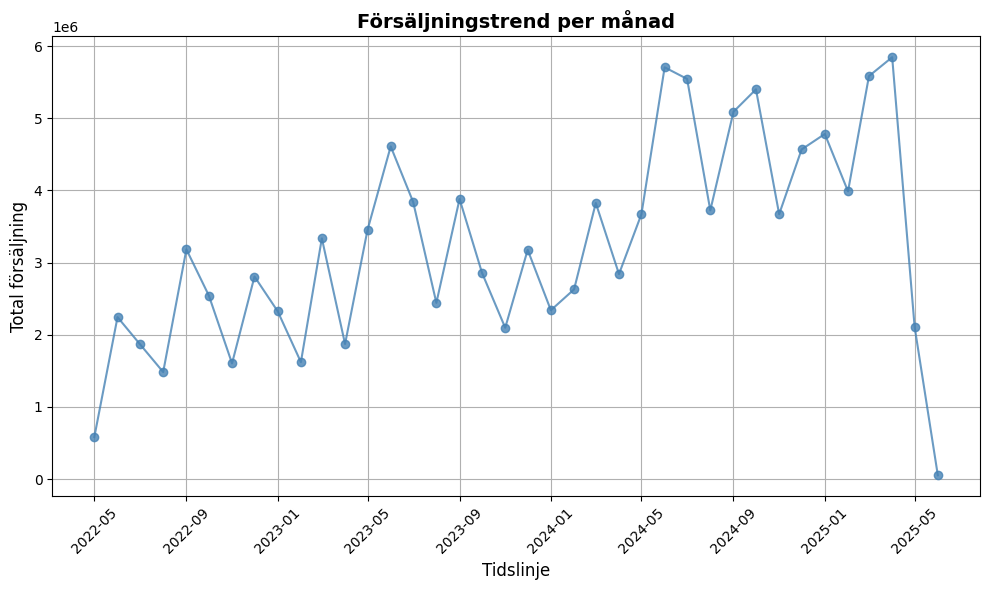

In [54]:
query_vis3 = """
SELECT
	YEAR(OrderDate) AS SalesYear,
	MONTH(OrderDate) AS SalesMonth,
	SUM(TotalDue) AS TotalSales
FROM Sales.SalesOrderHeader
GROUP BY
	YEAR(OrderDate),
	MONTH(OrderDate)
ORDER BY
	YEAR(OrderDate) ASC,
	MONTH(OrderDate) ASC
    """

df_vis3 = query_df(query_vis3)

df_vis3['SalesDate'] = pd.to_datetime(
    df_vis3.rename(columns={'SalesYear': 'year', 'SalesMonth': 'month'})
                .assign(day=1)[['year','month','day']]
)

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(df_vis3['SalesDate'], df_vis3['TotalSales'], marker = 'o', color='steelblue', alpha=0.8)

ax.set_xlabel('Tidslinje', fontsize=12)
ax.set_ylabel('Total försäljning', fontsize=12)
ax.set_title('Försäljningstrend per månad', fontsize=14, fontweight='bold')

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### Insikter - Försäljningstrend över tid
- Generellt stigande trend över åren 2022 - 2025.
- Slutet av juni 2025 ser ut som ett abrupt fall men TotalDue (total försäljning) visar beloppet som är fakturerat och/eller betalat. Många av dessa ordrar har förfallodatum (DueDate) i nästa månad (juli 2025). Därför kan det se ut som försäljningen plötsligt sjunker i den sista månaden. Maj 2022 har låg försäljning för att det inte finns data för hele månaden.
- Högsta månaden: april 2025 med en total försäljning på 5 847 164 USD (ca. 54 miljoner SEK).
- Lägsta månaden: om vi utesluter maj 2022 och juni 2025 eftersom de är ofullständiga så är augusti 2022 den lägsta månaden med en total försäljning på 1 483 277 USD (ca. 14 miljoner SEK).
- Försäljning är säsongsberoende: vi ser återkommande toppar under sommaren (juni-juli) och lägre försäljning på vintern.

## Visualisering 4: Försäljning och antal ordrar per år
Hur ser total försäljning och antal ordrar ut per år?

Tabeller som används:
- Sales.SalesOrderHeader

Plan:
- Beräkna total försäljning och antal ordrar per år
- Skapa grupperat stapeldiagram
- Analysera resultatet: Jämför åren - vilket år hade högst försäljning? Ökar både försäljning OCH antal ordrar, eller bara det ena?

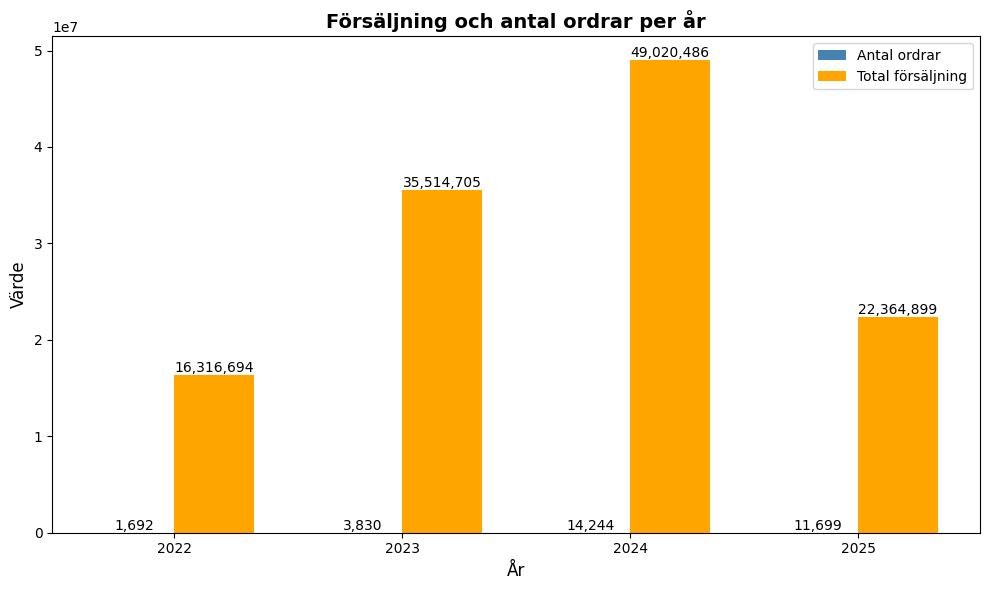

In [72]:
query_vis4 = """
SELECT
	YEAR(OrderDate) AS SalesYear,
	COUNT(DISTINCT SalesOrderID) AS AntalOrdrar,
	SUM(TotalDue) AS TotalSales
FROM Sales.SalesOrderHeader
GROUP BY
	YEAR(OrderDate)
ORDER BY
	YEAR(OrderDate) ASC
    """

df_vis4 = query_df(query_vis4)

x = np.arange(len(df_vis4))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))

bar1 = ax.bar(x - width/2, df_vis4['AntalOrdrar'], width, label='Antal ordrar', color='steelblue')
bar2 = ax.bar(x + width/2, df_vis4['TotalSales'], width, label='Total försäljning', color='orange')

for bars in [bar1, bar2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{int(height):,}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    ha='center', va='bottom')
        

ax.set_xlabel('År', fontsize=12)
ax.set_ylabel('Värde', fontsize=12)
ax.set_title('Försäljning och antal ordrar per år', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df_vis4['SalesYear'])
ax.legend()

plt.tight_layout()
plt.show()

### Insikter - Försäljning och antal ordrar per år
2022 och 2025 är datan ofullständig och visar bara halva året. Tittar vi på 2023 och 2024 så ser vi att båda försäljning och antal ordrar ökar. År 2024 hade högst försäljning med 49 020 486 USD (ca. 455 miljoner SEK).

## Visualisering 5: Top 10 produkter
Vilka 10 produkter genererar mest försäljning?

Tabeller som används:
- Production.Product
- Sales.SalesOrderDetail

Plan:
- JOINA tabellerna
- Beräkna top 10 produkter (högst till lägst försäljning)
- Skapa horisontellt stapeldiagram
- Analysera resultatet: Nämn #1 produkten med exakt försäljningsvärde. Vilken kategori dominerar topp 10?

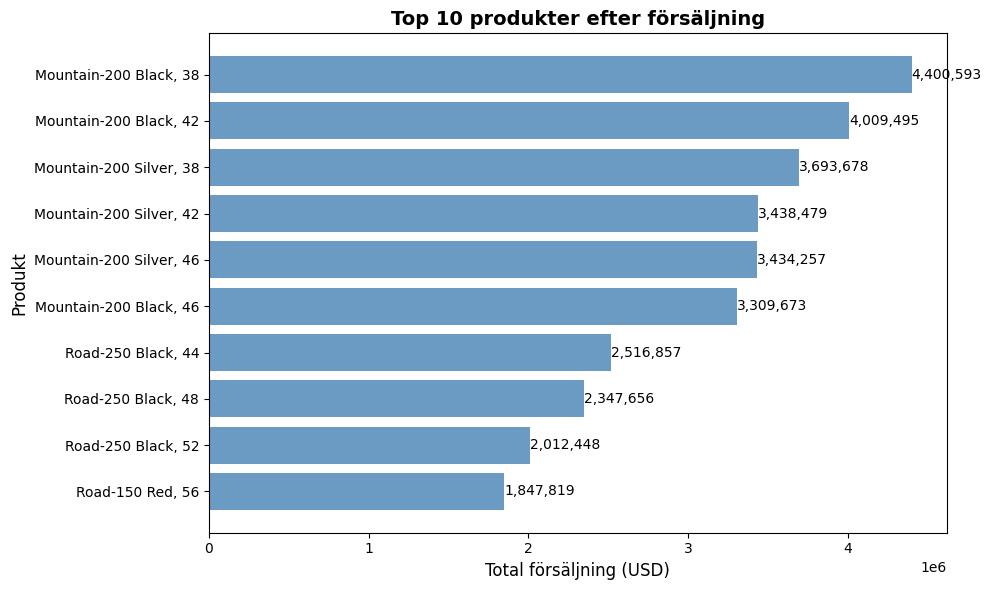

In [74]:
query_vis5 = """
SELECT TOP 10
	p.Name AS Namn,
	SUM(sod.LineTotal) AS TotalSales
FROM Production.Product p
INNER JOIN Sales.SalesOrderDetail sod ON p.ProductID = sod.ProductID
GROUP BY p.Name
ORDER BY TotalSales DESC
"""

df_vis5 = query_df(query_vis5)

fig, ax = plt.subplots(figsize=(10,6))

bars = ax.barh(df_vis5['Namn'], df_vis5['TotalSales'], color='steelblue', alpha=0.8)

for bar in bars:
    width = bar.get_width()
    ax.text(
    width,
    bar.get_y() + bar.get_height()/2,
    f'{width:,.0f}',
    va='center',
    ha='left'
    )

ax.set_xlabel('Total försäljning (USD)', fontsize=12)
ax.set_ylabel('Produkt', fontsize=12)
ax.set_title('Top 10 produkter efter försäljning', fontsize=14, fontweight='bold')
ax.invert_yaxis()

plt.tight_layout()
plt.show()

### Insikter -  Top 10 produkter
- #1 produkt är Mountain-200 Black, 38 med en total försäljning på 4 400 593 USD (ca. 41 miljoner SEK).
- Produktkategori Bikes (subkategorier Mountain Bikes och Road Bikes) dominerar topp 10.

## Visualisering 6: Försäljning och antal kunder per region
Hur skiljer sig försäljningen mellan olika regioner, och hur många unika kunder har varje region?

Tabeller som används:
- Sales.SalesTerritory
- Sales.SalesOrderHeader
- Sales.Customer

Plan:
- JOINA tabellerna
- Beräkna total försäljning och antal DISTINCT kunder per region
- Skapa grupperat stapeldiagram
- Analysera resultatet: Vilken region är starkast/svagast? Jämför: Har regionen med högst försäljning också flest kunder, eller har de färre kunder med högre ordervärde? Vad betyder det?

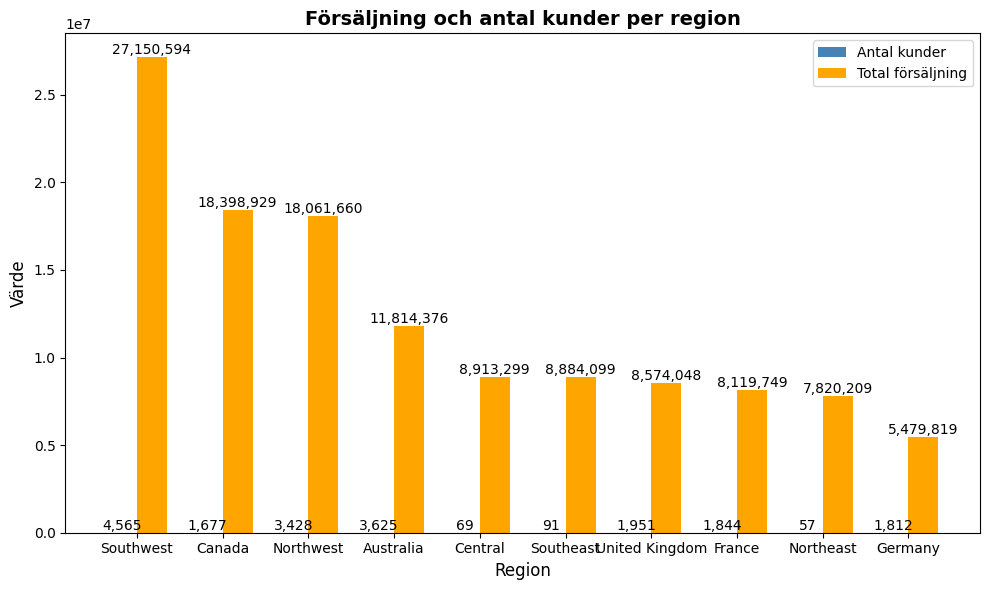

In [77]:
query_vis6 = """
SELECT
	COUNT(DISTINCT c.CustomerID) AS CustomerCount,
	st.Name AS Region,
	SUM(soh.TotalDue) AS TotalSales
FROM Sales.Customer c
INNER JOIN Sales.SalesOrderHeader soh ON c.CustomerID = soh.CustomerID
INNER JOIN Sales.SalesTerritory st ON soh.TerritoryID = st.TerritoryID
GROUP BY st.Name
ORDER BY TotalSales DESC
"""

df_vis6 = query_df(query_vis6)

x = np.arange(len(df_vis6))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))

bar1 = ax.bar(x - width/2, df_vis6['CustomerCount'], width, label='Antal kunder', color='steelblue')
bar2 = ax.bar(x + width/2, df_vis6['TotalSales'], width, label='Total försäljning', color='orange')

for bars in [bar1, bar2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{int(height):,}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    ha='center', va='bottom')
        

ax.set_xlabel('Region', fontsize=12)
ax.set_ylabel('Värde', fontsize=12)
ax.set_title('Försäljning och antal kunder per region', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df_vis6['Region'])
ax.legend()

plt.tight_layout()
plt.show()

### Insikter - Försäljning och antal kunder per region
Starkaste region: Southwest med både hög försäljning och många kunder. Svagaste region: Germany med lägre försäljning trots ett betydande antal kunder. Vissa regioner (Australia, Germany) har många kunder men låg ordervärde. Här kan man behöva höja orderstorleken eller sälja mer per kund. Vissa regioner (Central, Northeast) har få kunder men hög ordervärde per kund. Detta kan vara nischade marknader med stora kunder. Det är värt att titta närmare på detta.

## Visualisering 7: Genomsnittligt ordervärde per region och kundtyp
Vilka regioner har högst/lägst genomsnittligt ordervärde, och skiljer det sig mellan individuella kunder och företagskunder?

Tabeller som används:
- Sales.SalesTerritory
- Sales.SalesOrderHeader
- Sales.Customer
- Sales.Store

Plan:
- JOINA tabellerna
- Beräkna total försäljning / antal ordrar per region och dela upp på kundtyp (Store vs Individual)
- Skapa grupperat stapeldiagram
- Analysera resultatet: Jämför Store vs Individual - vilken grupp har högre ordervärde? Skiljer det sig mellan regioner? Vad kan förklara skillnaderna? Vilken region + kundtyp-kombination har högst ordervärde?

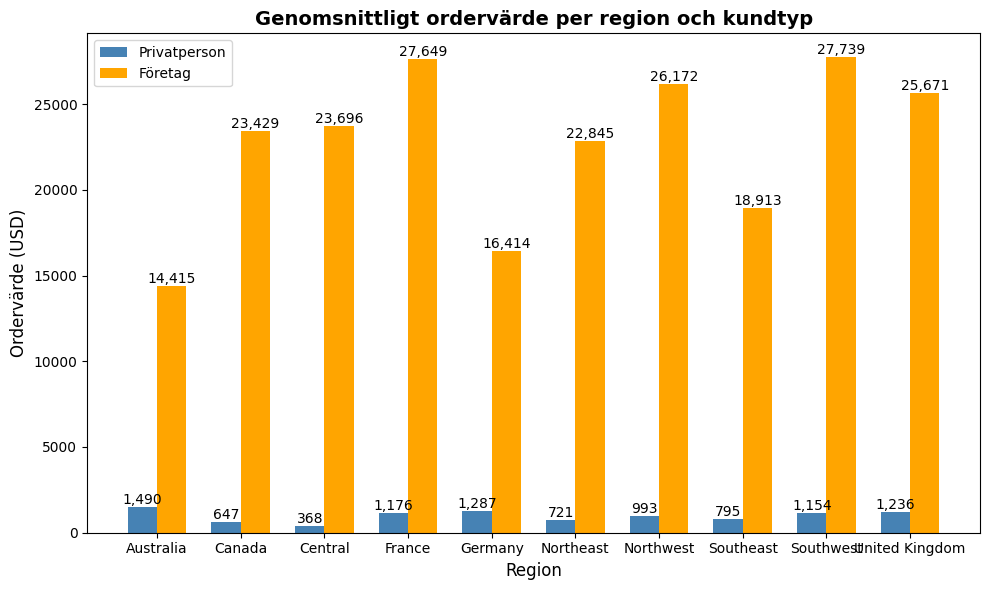

In [84]:
query_vis7 = """
SELECT
    st.Name AS Region,
    CASE 
        WHEN c.StoreID IS NOT NULL THEN 'Store'
		ELSE 'Individual'
    END AS CustomerType,
    SUM(soh.TotalDue) / COUNT(soh.SalesOrderID) AS OrderValue
FROM Sales.SalesOrderHeader soh
LEFT JOIN Sales.Customer c ON soh.CustomerID = c.CustomerID
INNER JOIN Sales.SalesTerritory st ON soh.TerritoryID = st.TerritoryID
GROUP BY
    st.Name,
    CASE 
        WHEN c.StoreID IS NOT NULL THEN 'Store'
		ELSE 'Individual'
    END
ORDER BY
    OrderValue DESC
    """

df_vis7 = query_df(query_vis7)

df_pivot = df_vis7.pivot(index='Region', columns='CustomerType', values='OrderValue').fillna(0)

x = np.arange(len(df_pivot))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))

bar1 = ax.bar(x - width/2, df_pivot['Individual'], width, label='Privatperson', color='steelblue')
bar2 = ax.bar(x + width/2, df_pivot['Store'], width, label='Företag', color='orange')

for bars in [bar1, bar2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{int(height):,}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    ha='center', va='bottom')
        

ax.set_xlabel('Region', fontsize=12)
ax.set_ylabel('Ordervärde (USD)', fontsize=12)
ax.set_title('Genomsnittligt ordervärde per region och kundtyp', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df_pivot.index)
ax.legend()

plt.tight_layout()
plt.show()


### Insikter: Genomsnittligt ordervärde per region och kundtyp


## Djupanalys - Alternativ

Tabeller som används:

Plan:

### Reflektion

### Sammanfattning